In [1]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import re

In [2]:
df = pd.read_csv("C:/Users/dadadah_ye/Downloads/total_data_11_27.csv", encoding = 'utf-8-sig')
df = df.dropna()
df['score'].value_counts()

1    82598
0    10218
Name: score, dtype: int64

In [3]:
# Solve data imbalanced
def under_sampling(df, target_label):
    rus  = RandomUnderSampler(return_indices=True)
    X_tl, y_tl, id_tl = rus.fit_sample(df, df[target_label])

    # remake data frame.
    columns = df.columns
    df = pd.DataFrame(X_tl, columns=columns)
    # df = df.astype(float)

    return df

df = under_sampling(df, "score")
df['score'].value_counts()

1    10218
0    10218
Name: score, dtype: int64

In [4]:
# remove emoji
def emoji(df):
    EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return EMOJI.sub(r'', df)

df['review'] = df['review'].apply(emoji)

# regular expression
def cleanText(df):
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', df)
    return text

df['review'] = df['review'].apply(cleanText)

In [5]:
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

mecab = Mecab('C:/mecab/mecab-ko-dic')
train, test = train_test_split(df, test_size=0.2)

train_x = []
train_y = []
test_x = []
test_y = []

for i, row in train.iterrows():
    train_x.append(['/'.join(token) for token in mecab.pos(row[0])])
    train_y.append(row[1])
    
for i, row in test.iterrows():
    test_x.append(['/'.join(token) for token in mecab.pos(row[0])])
    test_y.append(row[1])

In [6]:
tokens = [d for token in train_x for d in token]
tokens[0:10]

['사진/NNG',
 '은/JX',
 '예쁘/VA',
 '게/EC',
 '나오/VV',
 '고/EC',
 '참/MAG',
 '좋/VA',
 '았/EP',
 '어요/EF']

In [19]:
import nltk

text = nltk.Text(tokens, name='NMSC')
print(len(text))

1179471


### visualization most 50 words.

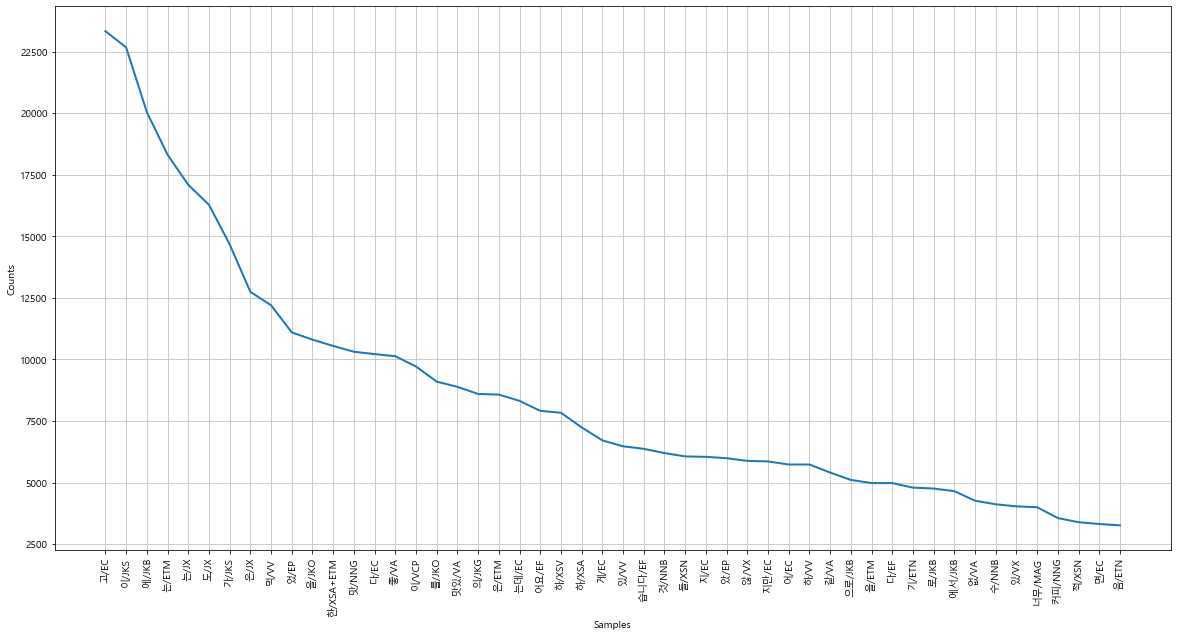

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [9]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]
selected_words[0:10]

['고/EC',
 '이/JKS',
 '에/JKB',
 '는/ETM',
 '는/JX',
 '도/JX',
 '가/JKS',
 '은/JX',
 '먹/VV',
 '었/EP']

In [10]:
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d in train_x]
test_x = [term_frequency(d) for d in test_x]
train_y = [c for c in train_y]
test_y = [c for c in test_y]

In [11]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [12]:
print(x_test.shape)
print(x_test)

(4088, 10000)
[[1. 0. 0. ... 0. 0. 0.]
 [3. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [3. 1. 1. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]]


### modeling

In [13]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

naivebayes = MultinomialNB()
naivebayes.fit(x_train, y_train)

'''for i in np.arange(0, 1.01, 0.05):
    threshold = i
    predicated_proba = naivebayes.predict_proba(x_test)
    predicted = (predicated_proba[:,1] >= i).astype('int')
    
    accuracy = accuracy_score(y_test, predicted)
    print('threshold = {}, accuracy = {}'.format(i, accuracy))'''

print('Navie Bayes accuracy = {}'.format(naivebayes.score(x_test,y_test)))

Navie Bayes accuracy = 0.7441291585127201


### ROC curve

In [14]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = naivebayes.predict(x_test).ravel()
#y_pred = (predicated_proba[:,1] >= 0.7).astype('int')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)
auc_curve

0.7444003765756178

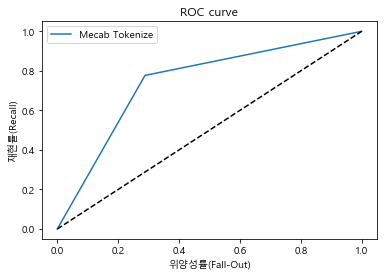

In [15]:
plt.plot(fpr, tpr, label='Mecab Tokenize')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC curve')
plt.show()

### Confusion Matrix

In [16]:
print(confusion_matrix(y_test, y_pred))
print('Recall = {}'.format(recall_score(y_test, y_pred)))

[[1467  594]
 [ 452 1575]]
Recall = 0.7770103601381352


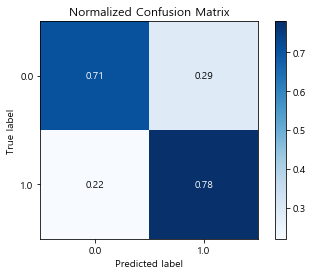

In [17]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

### F1-Score

In [18]:
print('F1 - Score = {}'.format(f1_score(y_test, y_pred)))

F1 - Score = 0.7507149666348903
